Dataset Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

First 5 Rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  ST

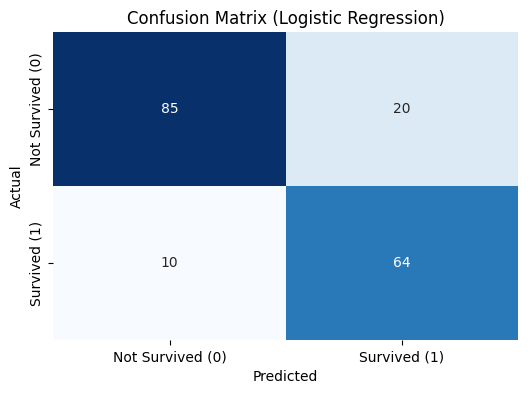

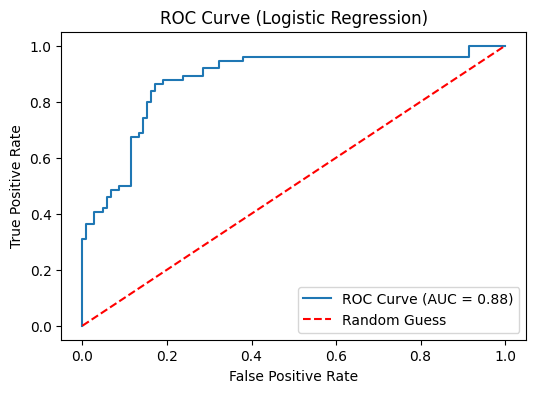


=== Random Forest Performance ===
Accuracy: 0.8045
Precision: 0.7600
Recall: 0.7703
F1-Score: 0.7651
ROC-AUC: 0.9025
5-Fold Cross-Validated ROC-AUC: 0.8598 (±0.0731)


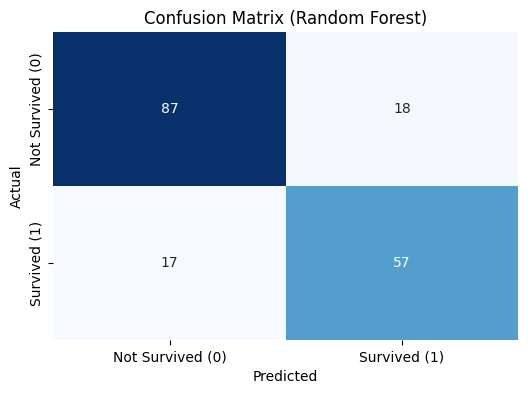

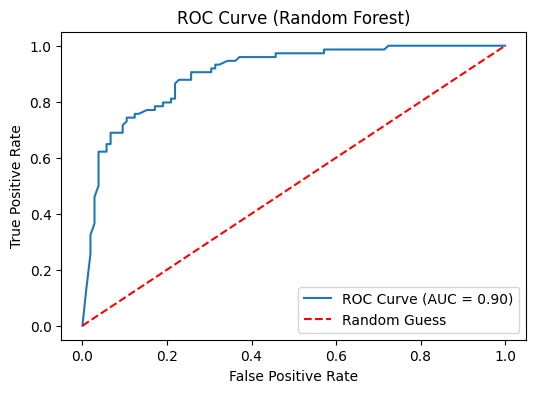

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# 1. Read the dataset using pd.read_csv
data = pd.read_csv('/Users/shriyog/Documents/SEM6/DMPM/LAB ESE/dataset/titanic.csv')

# Inspect the dataset to confirm column names
print("Dataset Columns:", data.columns.tolist())
print("\nFirst 5 Rows:")
print(data.head())

# 2. Feature Engineering
# Adjust column names to match standard Titanic CSV (e.g., Kaggle)
# If your CSV uses lowercase (e.g., 'survived', 'pclass'), update accordingly
data['FamilySize'] = data['SibSp'] + data['Parch']
data['IsAlone'] = (data['FamilySize'] == 0).astype(int)

# Bin Age and Fare
data['AgeBin'] = pd.cut(data['Age'], bins=[0, 12, 18, 30, 50, 100], labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])
data['FareBin'] = pd.qcut(data['Fare'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])

# Extract Title from Name
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
# Simplify titles
data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace(['Mlle', 'Ms'], 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')

# 3. Define features and target
# Adjust column names if necessary based on your CSV
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'AgeBin', 'FareBin', 'Title']
X = data[features]
y = data['Survived']

# 4. Preprocess the data
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'IsAlone', 'AgeBin', 'FareBin', 'Title']

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split data into training and test sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(preprocessor.fit_transform(X_train), y_train)
# Reapply preprocessor to test set
X_test_transformed = preprocessor.transform(X_test)

# 6. Build and tune logistic regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best logistic regression model
best_lr_model = grid_search.best_estimator_
print("\nBest Logistic Regression Parameters:", grid_search.best_params_)

# 7. Build Random Forest model for comparison
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# 8. Evaluate both models
models = {'Logistic Regression': best_lr_model, 'Random Forest': rf_model}

for name, model in models.items():
    # Fit the model
    model.fit(X_train_resampled, y_train_resampled)

    # Predict on test set
    y_pred = model.predict(X_test_transformed)
    y_pred_prob = model.predict_proba(X_test_transformed)[:, 1]

    # Performance metrics
    print(f"\n=== {name} Performance ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")

    # Cross-validated ROC-AUC
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
    print(f"5-Fold Cross-Validated ROC-AUC: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Survived (0)', 'Survived (1)'],
                yticklabels=['Not Survived (0)', 'Survived (1)'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({name})')
    plt.legend()
    plt.show()